In [1]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
from models.mae_with_hemisphere_embed_and_diff_dim_per_area import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.data_loader_ibl import *
from utils.mask import get_force_mask
from utils.metric_utils import Poisson_fraction_deviance_explained, get_deviance_explained

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'
import matplotlib.gridspec as gridspec
from sklearn.cluster import SpectralClustering

In [2]:
#load LFADS factors
factors_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/ibl_20sessions/factors_test.npy', allow_pickle=True).item()
rates_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/ibl_20sessions/rates_test.npy', allow_pickle=True).item()

#load lfads DFE files
dfe_lfads_pred = np.load('/work/hdd/bdye/jxia4/data/lfads_results/ibl_20sessions/dfe/lfads_dfe_pred.npy', allow_pickle=True).item()
fr_lfads_pred_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/ibl_20sessions/dfe/lfads_fr_pred_test.npy', allow_pickle=True).item()

In [4]:
#load RRR factors
RRR_factors_area_ind = np.load('/work/hdd/bdye/jxia4/data/RRR_results_IBL/preds_lat_area.npy', allow_pickle=True)
with open('/work/hdd/bdye/jxia4/data/RRR_results_IBL/preds_lat.pkl', 'rb') as f:
    RRR_factors = pickle.load(f)

#load RRR dfe files
dfe_RRR_pred = np.load('/work/hdd/bdye/jxia4/data/RRR_results_IBL/dfe/RRR_dfe_pred.npy', allow_pickle=True).item()
fr_RRR_pred_test = np.load('/work/hdd/bdye/jxia4/data/RRR_results_IBL/dfe/RRR_fr_pred_test.npy', allow_pickle=True).item()

In [6]:
session_order_file = "/work/hdd/bdye/jxia4/data/tables_and_infos/ibl_eids.txt"

with open(session_order_file, 'r') as file:
    eids = [line.strip() for line in file]

# Print loaded eids for debugging
print(f"Loaded eids: {eids}")

Loaded eids: ['f312aaec-3b6f-44b3-86b4-3a0c119c0438', '51e53aff-1d5d-4182-a684-aba783d50ae5', '88224abb-5746-431f-9c17-17d7ef806e6a', 'c7248e09-8c0d-40f2-9eb4-700a8973d8c8', '4b00df29-3769-43be-bb40-128b1cba6d35', 'a8a8af78-16de-4841-ab07-fde4b5281a03', 'ebe090af-5922-4fcd-8fc6-17b8ba7bad6d', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', 'dc962048-89bb-4e6a-96a9-b062a2be1426', '0841d188-8ef2-4f20-9828-76a94d5343a4', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '9b528ad0-4599-4a55-9148-96cc1d93fb24', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'ecb5520d-1358-434c-95ec-93687ecd1396', '4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', '15b69921-d471-4ded-8814-2adad954bcd8', '49e0ab27-827a-4c91-bcaa-97eea27a1b8d', '7f6b86f9-879a-4ea2-8531-294a221af5d0', '4fa70097-8101-4f10-b585-db39429c5ed0']


In [7]:
base_path = '/work/hdd/bdye/jxia4/results/mae_results'
num_train_sessions = len(eids)

mask_mode = 'region'

region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5
consistency = True

num_epochs = 1000
batch_size = 16
use_wandb = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area_ibl.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list, heldout_info_list, trial_type_dict = make_loader(eids, batch_size, seed=config.seed)
set_seed(config.seed) 

  0%|          | 0/20 [00:00<?, ?it/s]

f312aaec-3b6f-44b3-86b4-3a0c119c0438
EID f312aaec-3b6f-44b3-86b4-3a0c119c0438
Loading EID f312aaec-3b6f-44b3-86b4-3a0c119c0438 from cached data
Brain region summary: 
{'PO': 174, 'LP': 206, 'DG': 123, 'CA1': 234, 'VISa': 314, 'VPM': 0, 'APN': 172, 'MRN': 56}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18}
Spike data shape:  (1504, 200, 533)
Spike data shape after removing unrecorded areas:  (1298, 200, 533)


  5%|▌         | 1/20 [00:05<01:37,  5.11s/it]

51e53aff-1d5d-4182-a684-aba783d50ae5
EID 51e53aff-1d5d-4182-a684-aba783d50ae5
Loading EID 51e53aff-1d5d-4182-a684-aba783d50ae5 from cached data
Brain region summary: 
{'PO': 217, 'LP': 102, 'DG': 88, 'CA1': 90, 'VISa': 74, 'VPM': 28, 'APN': 143, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29}
Spike data shape:  (1189, 200, 321)
Spike data shape after removing unrecorded areas:  (1115, 200, 321)


 10%|█         | 2/20 [00:07<01:04,  3.59s/it]

88224abb-5746-431f-9c17-17d7ef806e6a
EID 88224abb-5746-431f-9c17-17d7ef806e6a
Loading EID 88224abb-5746-431f-9c17-17d7ef806e6a from cached data
Brain region summary: 
{'PO': 303, 'LP': 57, 'DG': 76, 'CA1': 84, 'VISa': 2, 'VPM': 0, 'APN': 0, 'MRN': 2}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'): 

 15%|█▌        | 3/20 [00:09<00:51,  3.02s/it]

c7248e09-8c0d-40f2-9eb4-700a8973d8c8
EID c7248e09-8c0d-40f2-9eb4-700a8973d8c8
Loading EID c7248e09-8c0d-40f2-9eb4-700a8973d8c8 from cached data
Brain region summary: 
{'PO': 257, 'LP': 152, 'DG': 8, 'CA1': 82, 'VISa': 245, 'VPM': 35, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 20%|██        | 4/20 [00:12<00:47,  2.98s/it]

4b00df29-3769-43be-bb40-128b1cba6d35
EID 4b00df29-3769-43be-bb40-128b1cba6d35
Loading EID 4b00df29-3769-43be-bb40-128b1cba6d35 from cached data
Brain region summary: 
{'PO': 62, 'LP': 118, 'DG': 113, 'CA1': 56, 'VISa': 5, 'VPM': 122, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 25%|██▌       | 5/20 [00:16<00:45,  3.04s/it]

a8a8af78-16de-4841-ab07-fde4b5281a03
EID a8a8af78-16de-4841-ab07-fde4b5281a03
Loading EID a8a8af78-16de-4841-ab07-fde4b5281a03 from cached data
Brain region summary: 
{'PO': 10, 'LP': 281, 'DG': 351, 'CA1': 340, 'VISa': 93, 'VPM': 43, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 30%|███       | 6/20 [00:19<00:46,  3.33s/it]

ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
EID ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
Loading EID ebe090af-5922-4fcd-8fc6-17b8ba7bad6d from cached data
Brain region summary: 
{'PO': 103, 'LP': 152, 'DG': 113, 'CA1': 132, 'VISa': 121, 'VPM': 495, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 35%|███▌      | 7/20 [00:26<00:58,  4.47s/it]

6c6b0d06-6039-4525-a74b-58cfaa1d3a60
EID 6c6b0d06-6039-4525-a74b-58cfaa1d3a60
Loading EID 6c6b0d06-6039-4525-a74b-58cfaa1d3a60 from cached data
Brain region summary: 
{'PO': 0, 'LP': 8, 'DG': 275, 'CA1': 226, 'VISa': 208, 'VPM': 0, 'APN': 428, 'MRN': 225}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tract

 40%|████      | 8/20 [00:33<01:01,  5.16s/it]

dc962048-89bb-4e6a-96a9-b062a2be1426
EID dc962048-89bb-4e6a-96a9-b062a2be1426
Loading EID dc962048-89bb-4e6a-96a9-b062a2be1426 from cached data
Brain region summary: 
{'PO': 0, 'LP': 73, 'DG': 163, 'CA1': 215, 'VISa': 218, 'VPM': 0, 'APN': 349, 'MRN': 155}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber trac

 45%|████▌     | 9/20 [00:35<00:45,  4.15s/it]

0841d188-8ef2-4f20-9828-76a94d5343a4
EID 0841d188-8ef2-4f20-9828-76a94d5343a4
Loading EID 0841d188-8ef2-4f20-9828-76a94d5343a4 from cached data
Brain region summary: 
{'PO': 0, 'LP': 94, 'DG': 291, 'CA1': 257, 'VISa': 156, 'VPM': 0, 'APN': 416, 'MRN': 104}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber trac

 50%|█████     | 10/20 [00:37<00:36,  3.63s/it]

3e6a97d3-3991-49e2-b346-6948cb4580fb
EID 3e6a97d3-3991-49e2-b346-6948cb4580fb
Loading EID 3e6a97d3-3991-49e2-b346-6948cb4580fb from cached data
Brain region summary: 
{'PO': 0, 'LP': 1, 'DG': 220, 'CA1': 329, 'VISa': 167, 'VPM': 0, 'APN': 454, 'MRN': 69}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 55%|█████▌    | 11/20 [00:42<00:35,  3.95s/it]

9b528ad0-4599-4a55-9148-96cc1d93fb24
EID 9b528ad0-4599-4a55-9148-96cc1d93fb24
Loading EID 9b528ad0-4599-4a55-9148-96cc1d93fb24 from cached data
Brain region summary: 
{'PO': 0, 'LP': 7, 'DG': 36, 'CA1': 159, 'VISa': 88, 'VPM': 0, 'APN': 166, 'MRN': 116}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 60%|██████    | 12/20 [00:44<00:26,  3.32s/it]

e2b845a1-e313-4a08-bc61-a5f662ed295e
EID e2b845a1-e313-4a08-bc61-a5f662ed295e
Loading EID e2b845a1-e313-4a08-bc61-a5f662ed295e from cached data
Brain region summary: 
{'PO': 0, 'LP': 146, 'DG': 268, 'CA1': 452, 'VISa': 452, 'VPM': 0, 'APN': 469, 'MRN': 232}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 65%|██████▌   | 13/20 [00:50<00:29,  4.14s/it]

2bdf206a-820f-402f-920a-9e86cd5388a4
EID 2bdf206a-820f-402f-920a-9e86cd5388a4
Loading EID 2bdf206a-820f-402f-920a-9e86cd5388a4 from cached data
Brain region summary: 
{'PO': 0, 'LP': 188, 'DG': 283, 'CA1': 317, 'VISa': 220, 'VPM': 0, 'APN': 305, 'MRN': 221}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 70%|███████   | 14/20 [00:56<00:28,  4.73s/it]

ecb5520d-1358-434c-95ec-93687ecd1396
EID ecb5520d-1358-434c-95ec-93687ecd1396
Loading EID ecb5520d-1358-434c-95ec-93687ecd1396 from cached data
Brain region summary: 
{'PO': 0, 'LP': 8, 'DG': 304, 'CA1': 364, 'VISa': 441, 'VPM': 0, 'APN': 457, 'MRN': 68}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 75%|███████▌  | 15/20 [01:00<00:21,  4.39s/it]

4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
EID 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
Loading EID 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b from cached data
Brain region summary: 
{'PO': 0, 'LP': 32, 'DG': 95, 'CA1': 107, 'VISa': 210, 'VPM': 0, 'APN': 74, 'MRN': 98}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 80%|████████  | 16/20 [01:05<00:18,  4.62s/it]

15b69921-d471-4ded-8814-2adad954bcd8
EID 15b69921-d471-4ded-8814-2adad954bcd8
Loading EID 15b69921-d471-4ded-8814-2adad954bcd8 from cached data
Brain region summary: 
{'PO': 156, 'LP': 82, 'DG': 288, 'CA1': 176, 'VISa': 206, 'VPM': 82, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tract

 85%|████████▌ | 17/20 [01:10<00:14,  4.78s/it]

49e0ab27-827a-4c91-bcaa-97eea27a1b8d
EID 49e0ab27-827a-4c91-bcaa-97eea27a1b8d
Loading EID 49e0ab27-827a-4c91-bcaa-97eea27a1b8d from cached data
Brain region summary: 
{'PO': 0, 'LP': 0, 'DG': 56, 'CA1': 265, 'VISa': 0, 'VPM': 0, 'APN': 414, 'MRN': 80}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'):

 90%|█████████ | 18/20 [01:17<00:10,  5.38s/it]

7f6b86f9-879a-4ea2-8531-294a221af5d0
EID 7f6b86f9-879a-4ea2-8531-294a221af5d0
Loading EID 7f6b86f9-879a-4ea2-8531-294a221af5d0 from cached data
Brain region summary: 
{'PO': 0, 'LP': 0, 'DG': 312, 'CA1': 575, 'VISa': 507, 'VPM': 0, 'APN': 541, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 95%|█████████▌| 19/20 [01:27<00:06,  6.88s/it]

4fa70097-8101-4f10-b585-db39429c5ed0
EID 4fa70097-8101-4f10-b585-db39429c5ed0
Loading EID 4fa70097-8101-4f10-b585-db39429c5ed0 from cached data
Brain region summary: 
{'PO': 18, 'LP': 7, 'DG': 0, 'CA1': 4, 'VISa': 0, 'VPM': 281, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'): 39

100%|██████████| 20/20 [01:28<00:00,  4.44s/it]

num_neurons:  [1073, 668, 444, 744, 358, 1108, 995, 1095, 824, 902, 1170, 565, 1751, 1229, 1201, 518, 784, 735, 1360, 299]
num_trials:  {'train': [319, 192, 252, 424, 398, 252, 499, 485, 194, 218, 297, 305, 237, 301, 241, 406, 444, 444, 492, 237], 'val': [107, 64, 84, 142, 133, 84, 167, 162, 65, 73, 99, 102, 79, 100, 80, 135, 148, 148, 164, 79], 'test': [107, 65, 84, 142, 133, 84, 167, 162, 65, 73, 100, 102, 79, 101, 81, 136, 149, 148, 165, 79]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test
seed set to 42


In [8]:
test_dataloader = dataloader['test']
areaoi_ind = np.array(areaoi_ind)

In [8]:
def get_pred_fr_and_dfe(factors_region, spikes_region, n_trial_train, device):
    '''
    factors_region: B x T x C
    spikes_region: B x T x N
    n_trial_train: int
    device: torch.device

    return: fr_pred_test, dfe_test
    '''

    factors_region_train = factors_region[:n_trial_train]
    spikes_region_train = spikes_region[:n_trial_train]

    factors_region_test = factors_region[n_trial_train:]
    spikes_region_test = spikes_region[n_trial_train:]

    fr_pred_train, weight, bias, dfe_train = get_deviance_explained(factors_region_train, spikes_region_train, device, verbose=True)
    fr_pred_test = torch.exp(factors_region_test @ weight + bias[None, None, :])

    if torch.any(torch.isnan(fr_pred_test)):
        print('nan in fr_pred_test using recorded data', ', session ', eid)
        return fr_pred_test, spikes_region_test, None

    dfe_test = Poisson_fraction_deviance_explained(fr_pred_test.cpu().detach().numpy(), spikes_region_test.cpu().detach().numpy())
    
    return fr_pred_test, spikes_region_test, dfe_test

In [9]:
accelerator = Accelerator()
device = accelerator.device
print(device)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


cuda


In [18]:
## run this cell to calculate and save lfads DFE files (performance metrics for LFADS)

# set_seed(config.seed)  

# dfe_lfads_pred = {}
# fr_lfads_pred_test = {}


# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]


#         spikes_data = batch['spikes_data']
#         print('batch spike', spikes_data.shape)
        
#         # for i in range(40):
#         #     spike_data_lfads = spikes_test[i]
#         #     if (spike_data_lfads.shape[0]==spikes_data.shape[0]) and (spike_data_lfads.shape[2]==spikes_data.shape[2]):
#         #         break
#         spikes_data_lfads = rates_test[eid]
#         if spikes_data_lfads.shape != spikes_data.shape:
#             print('spike data shape not match', spikes_data_lfads.shape, spikes_data.shape)
#             break
        
#         dfe_lfads_pred[eid] = {}
#         fr_lfads_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         lfads_factors = torch.from_numpy(factors_test[eid]).to(device)

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(lfads_factors, spikes_region, n_trial_train, device)

#             dfe_lfads_pred[eid][area_ind] = dfe_test
#             fr_lfads_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/lfads_results/ibl_20sessions/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'lfads_dfe_pred.npy', dfe_lfads_pred)
# np.save(save_path+'lfads_fr_pred_test.npy', fr_lfads_pred_test)

seed set to 42
0
batch spike torch.Size([107, 200, 1073])
epoch 7 converged. 


/work/hdd/bdye/jxia4/code/autoencoder_mae/src/utils/metric_utils.py:133: RuntimeWarning: divide by zero encountered in divide
  return 1 - (nll_model - nll_sat) / (nll_null - nll_sat)


epoch 7 converged. 
epoch 6 converged. 
epoch 7 converged. 
epoch 4 converged. 
epoch 7 converged. 
epoch 7 converged. 
17
batch spike torch.Size([148, 200, 735])
epoch 4 converged. 
epoch 7 converged. 
epoch 7 converged. 
epoch 3 converged. 
15
batch spike torch.Size([136, 200, 518])
epoch 2 converged. 
epoch 8 converged. 
epoch 5 converged. 
epoch 4 converged. 
epoch 2 converged. 
epoch 9 converged. 
1
batch spike torch.Size([65, 200, 668])
epoch 8 converged. 
epoch 7 converged. 
epoch 4 converged. 
epoch 7 converged. 
epoch 7 converged. 
epoch 6 converged. 
epoch 7 converged. 
8
batch spike torch.Size([65, 200, 824])
epoch 8 converged. 
epoch 5 converged. 
epoch 9 converged. 
epoch 7 converged. 
epoch 5 converged. 
epoch 9 converged. 
5
batch spike torch.Size([84, 200, 1108])
epoch 2 converged. 
epoch 3 converged. 
epoch 4 converged. 
epoch 5 converged. 
epoch 4 converged. 
epoch 2 converged. 
11
batch spike torch.Size([102, 200, 565])
epoch 3 converged. 
epoch 4 converged. 
epoch 5

neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 3 converged. 
epoch 3 converged. 
epoch 5 converged. 
epoch 4 converged. 
18
batch spike torch.Size([165, 200, 1360])
epoch 3 converged. 
epoch 5 converged. 
epoch 2 converged. 
epoch 6 converged. 
16
batch spike torch.Size([149, 200, 784])
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 8 converged. 
epoch 7 converged. 
13
batch spike torch.Size([101, 200, 1229])
epoch 2 converged. 
epoch 4 converged. 
epoch 5 converged. 
epoch 9 converged. 
epoch 8 converged. 
epoch 5 converged. 
2
batch spike torch.Size([84, 200, 444])
epoch 6 converged. 
epoch 2 converged. 
epoch 6 converged. 
epoch 6 converged. 
9
batch spike torch.Size([73, 200, 902])
epoch 8 converged. 
epoch 6 converged. 
epoch 5 converged. 
epoch 7 converged. 
epoch 9 converged. 
epoch 5 converged. 
19
batch spike torch.Size([79, 200, 299])
epoch 3 converged. 
epoch 2 converged. 
epoch 6 converged. 
4
batch spike torch.Size([133, 200, 358])
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 6 converged. 
epoch 7 converged. 
12
batch spike torch.Size([79, 200, 1751])
epoch 8 converged. 
epoch 6 converged. 
epoch 9 converged. 
epoch 9 converged. 
epoch 3 converged. 
epoch 3 converged. 
7
batch spike torch.Size([162, 200, 1095])
epoch 3 converged. 
epoch 3 converged. 
epoch 4 converged. 
epoc

In [10]:
## run this cell to calculate and save RRR DFE files (performance metrics for RRR)

# set_seed(config.seed)  

# dfe_RRR_pred = {}
# fr_RRR_pred_test = {}

# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]


#         spikes_data = batch['spikes_data']

#         dfe_RRR_pred[eid] = {}
#         fr_RRR_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue
            
#             RRR_factors_region = torch.from_numpy(RRR_factors[str(eid)][:,:,RRR_factors_area_ind==area_ind]).to(device)

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(RRR_factors_region, spikes_region, n_trial_train, device)

#             dfe_RRR_pred[eid][area_ind] = dfe_test
#             fr_RRR_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/RRR_results_IBL/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'RRR_dfe_pred.npy', dfe_RRR_pred)
# np.save(save_path+'RRR_fr_pred_test.npy', fr_RRR_pred_test)


seed set to 42
0
epoch 8 converged. 


/work/hdd/bdye/jxia4/code/autoencoder_mae/src/utils/metric_utils.py:133: RuntimeWarning: divide by zero encountered in divide
  return 1 - (nll_model - nll_sat) / (nll_null - nll_sat)


epoch 5 converged. 
epoch 7 converged. 
epoch 6 converged. 
epoch 8 converged. 
epoch 7 converged. 
epoch 12 converged. 
17
epoch 11 converged. 
epoch 12 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 2 converged. 


/work/hdd/bdye/jxia4/code/autoencoder_mae/src/utils/metric_utils.py:82: RuntimeWarning: invalid value encountered in multiply
  result = rates - spikes * np.log(rates) + gammaln(spikes + 1.0)
/work/hdd/bdye/jxia4/code/autoencoder_mae/src/utils/metric_utils.py:82: RuntimeWarning: invalid value encountered in subtract
  result = rates - spikes * np.log(rates) + gammaln(spikes + 1.0)
/work/hdd/bdye/jxia4/code/autoencoder_mae/src/utils/metric_utils.py:133: RuntimeWarning: invalid value encountered in divide
  return 1 - (nll_model - nll_sat) / (nll_null - nll_sat)
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 4 converged. 
15
epoch 5 converged. 
epoch 5 converged. 
epoch 13 converged. 
epoch 2 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 6 converged. 
epoch 13 converged. 
1
epoch 10 converged. 
epoch 8 converged. 
epoch 7 converged. 
epoch 10 converged. 
epoch 4 converged. 
epoch 9 converged. 
epoch 6 converged. 
8
epoch 9 converged. 
epoch 5 converged. 
epoch 10 converged. 
epoch 13 converged. 
epoch 14 converged. 
epoch 9 converged. 
5
epoch 5 converged. 
epoch 6 converged. 
epoch 10 converged. 
epoch 8 converged. 
epoch 10 converged. 
epoch 13 converged. 
11
epoch 2 converged. 
epoch 9 converged. 
epoch 11 converged. 
epoch 8 converged. 
epoch 7 converged. 
epoch 13 converged. 
3
epoch 8 converged. 
epoch 9 converged. 
epoch 6 converged. 
epoch 16 converged. 
epoch 20 converged. 
epoch 10 converged. 
18
epoch 11 converged. 
epoch 10 converged. 
epoch 14 converged. 
epoch 11 converged. 
16
epoch 12 converged. 
epoch 6 converged. 
epoch 9 converged. 
epoch 14 converged. 
epoch 13 converged. 
epoch 14 converged. 
13
epoch 7 converged. 
epoch 12 converged. 
epoch 12 converged. 
epoch 16 converged. 
epoch 8 converg

neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 2 converged. 
2
epoch 13 converged. 
epoch 11 converged. 
epoch 2 converged. 
epoch 11 converged. 
9
epoch 9 converged. 
epoch 8 converged. 
epoch 11 converged. 
epoch 18 converged. 
epoch 6 converged. 
epoch 12 converged. 
19
epoch 22 converged. 
epoch 5 converged. 
4
epoch 12 converged. 
epoch 4 converged. 
epoch 6 converged. 
epoch 8 converged. 
epoch 13 converged. 
12
epoch 8 converged. 
epoch 9 converged. 
epoch 14 converged. 
epoch 16 converged. 
epoch 10 converged. 
epoch 16 converged. 
7
epoch 3 converged. 
epoch 9 converged. 
epoch 10 converged. 
epoch 9 converged. 
epoch 6 converged. 
epoch 16 converged. 
10
epoch 12 converged. 
epoch 12 converged. 
epoch 14 converged. 
epoch 11 converged. 
epoch 11 converged. 
14
epoch 4 converged. 
epoch 14 converged. 
epoch 9 converged. 
epoch 2 converged. 
epoch 13 converged. 
epoch 12 converged. 
6
epoch 9 converged. 
epoch 9 converged. 
epoch 11 converged. 
epoch 13 converged. 
epoch 10 converged. 
epoch 14 converged. 


In [9]:
with_reg = True
consistency = True
region_channel_num_encoder = 48
unit_embed_dim = 50
n_layers = 5
num_train_sessions = 20
base_path = '/work/hdd/bdye/jxia4/results/mae_results/'

save_path = f'{base_path}eval/ibl_wo_trial_type_embed/with_reg_{with_reg}_2check/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/dfe/'

dfe_no_mask_pred = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
dfe_no_mask_from_record_to_heldout= np.load(save_path + 'dfe_no_mask_from_record_to_heldout.npy', allow_pickle=True).item()
baseline_no_mask_fr_pred_test = np.load(save_path + 'baseline_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
spike_test = np.load(save_path + 'spike_test_save.npy', allow_pickle=True).item()


In [10]:
brain_region_list = ["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"]

/tmp/ipykernel_657246/4035121381.py:33: RuntimeWarning: divide by zero encountered in log
  sc1 = ax1.scatter(dfe_lfads_pred[eid_ind][area_ind], dfe_no_mask_pred[eid_ind][area_ind], c=np.log(mean_spike_number), cmap='magma')
/tmp/ipykernel_657246/4035121381.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


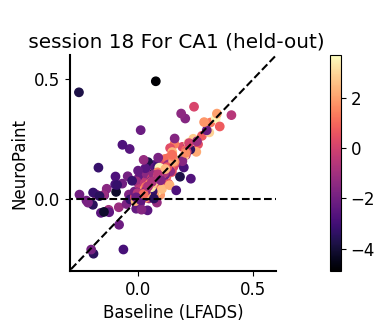

In [ ]:
# for eid_ind in range(len(heldout_info_list)):
for eid_ind in [18]:
    #eid = heldout_info_list[eid_ind]['session_ind']
    area_ind = heldout_info_list[eid_ind]['heldout_region_ind']

    spike_region_test = spike_test[eid_ind][area_ind]
    mean_spike_number = np.mean(spike_region_test, axis=(0,1))*100 #unit Hz.

    min = -0.3
    max = 0.6

    if eid_ind not in dfe_no_mask_pred.keys():
        print(eid_ind)
        print('no eid in dfe_no_mask_pred')
        continue


    if area_ind not in dfe_no_mask_pred[eid_ind].keys():
        print(eid_ind)
        print('no area_ind in dfe_no_mask_pred')
        continue

    if dfe_no_mask_pred[eid_ind][area_ind] is None:
        print(eid_ind)
        print('dfe_no_mask_pred[eid][area_ind] is None')
        continue

    fig = plt.figure(figsize=(3.5,2.8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.5) 
    ax1 = plt.subplot(gs[0])
    plt.title(f'\n session {eid_ind} For {brain_region_list[area_ind]} (held-out)')
    sc1 = ax1.scatter(dfe_lfads_pred[eid_ind][area_ind], dfe_no_mask_pred[eid_ind][area_ind], c=np.log(mean_spike_number), cmap='magma')
    ax1.set_xlabel('Baseline (LFADS)')
    ax1.set_ylabel('NeuroPaint')
    ax1.plot([-1,1],[-1,1], 'k--')
    ax1.plot([-1,1],[0,0], 'k--')
    ax1.set_xlim([min,max])
    ax1.set_ylim([min,max])
    ax1.set_xticks([0, max-0.1])
    ax1.set_yticks([0, max-0.1])

    # Style adjustments
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    cbar_ax = plt.subplot(gs[1])
    cbar = fig.colorbar(sc1, cax=cbar_ax)

    plt.tight_layout()
    #plt.savefig(figure_path + f'fig3/IBL_dfe_no_mask_pred_{eid_ind}_{area_ind}_w_log_fr.pdf', transparent=True)



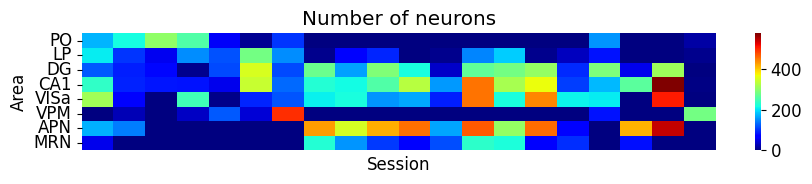

In [8]:
#load ibl_region_neuron_count
ibl_region_neuron_count = np.load('/work/hdd/bdye/jxia4/data/tables_and_infos/ibl_region_neuron_count.npy', allow_pickle=True).item()
ibl_region_neuron_count
ibl_n_neuron_matrix = np.zeros((20, 8))

for i, eid in enumerate(range(20)):
    for j, area_name in enumerate(["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"]):
        if eid in ibl_region_neuron_count.keys():
            if area_name in ibl_region_neuron_count[eid].keys():
                ibl_n_neuron_matrix[i,j] = ibl_region_neuron_count[eid][area_name]
            else:
                ibl_n_neuron_matrix[i,j] = 0
        else:
            ibl_n_neuron_matrix[i,j] = 0
plt.figure(figsize=(9,2))
sns.heatmap(ibl_n_neuron_matrix.T, cmap='jet')
plt.yticks(np.arange(8)+0.5, ["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"], rotation=0)
plt.xticks([])
plt.xlabel('Session')
plt.ylabel('Area')
plt.title('Number of neurons')
plt.tight_layout()
#plt.savefig(figure_path + 'n_neuron_matrix_IBL_wide.pdf', transparent=True)

/tmp/ipykernel_657246/2113682305.py:9: RuntimeWarning: invalid value encountered in subtract
  neuron_id_sort = np.argsort(dfe_mae-dfe_baseline)[::-1]


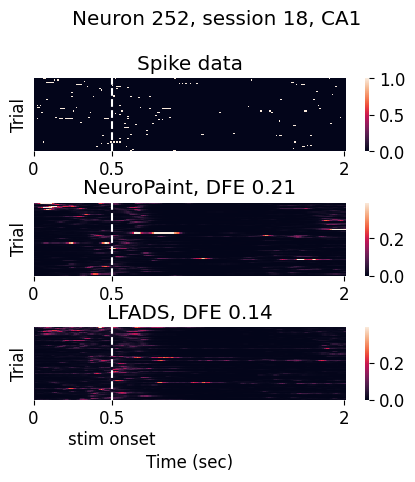

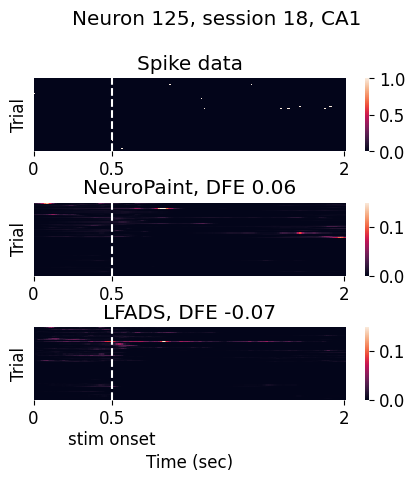

In [52]:
eid_ind = 18
area_ind = heldout_info_list[eid_ind]['heldout_region_ind']
eid = eid_ind

dfe_mae = dfe_no_mask_pred[eid][area_ind]
dfe_baseline = dfe_lfads_pred[eid][area_ind]

neuron_id_sort = np.argsort(dfe_mae-dfe_baseline)[::-1]

mae_fr_pred_test = mae_no_mask_fr_pred_test[eid][area_ind]
baseline_fr_pred_test = fr_lfads_pred_test[eid][area_ind].detach().cpu().numpy()

spike_region_test = spike_test[eid][area_ind]
for i in [60,41]:
    tmp = mae_fr_pred_test[:,:,neuron_id_sort[i]]

    #sort trials based on clustering gt_
    clustering = SpectralClustering(n_clusters=3, n_neighbors=5,
                    affinity='nearest_neighbors',
                    assign_labels='discretize',
                    random_state=0)

    clustering = clustering.fit(tmp)
    trial_sort = np.argsort(clustering.labels_)


    plt.figure(figsize=(4.5, 4.9))
    plt.subplot(3, 1, 1)
    sns.heatmap(spike_region_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=1)
    plt.ylabel('Trial')
    plt.axvline(50, color='w', linestyle='--')
    plt.yticks([])
    plt.xticks([0, 50, 199], [0, '0.5', 2], rotation=0)

    vmin = np.min([np.min(tmp), np.min(baseline_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort])])
    vmax = np.min([np.max(tmp), np.max(baseline_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort])])

    plt.title(f'Spike data')
    plt.subplot(3, 1, 2)
    sns.heatmap(mae_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=vmax)
    plt.ylabel('Trial')
    plt.axvline(50, color='w', linestyle='--')
    plt.yticks([])
    plt.xticks([0, 50, 199], [0, '0.5', 2], rotation=0)


    plt.title(f'NeuroPaint, DFE {dfe_mae[neuron_id_sort[i]]:.2f}')
    plt.subplot(3, 1, 3)
    sns.heatmap(baseline_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=vmax)
    plt.ylabel('Trial')
    plt.axvline(50, color='w', linestyle='--')
    plt.yticks([])
    plt.xticks([0, 50, 199], [0, '0.5\nstim onset', 2], rotation=0)

    plt.xlabel('Time (sec)')


    plt.title(f'LFADS, DFE {dfe_baseline[neuron_id_sort[i]]:.2f}')

    plt.suptitle(f'Neuron {neuron_id_sort[i]}, session {eid}, {brain_region_list[area_ind]}')



    plt.tight_layout()
    #set pad btw subplots
    plt.subplots_adjust(hspace=0.7)
    #plt.savefig(f'/work/hdd/bdye/jxia4/results/figures/fig3/IBL_heldout_region_{brain_region_list[area_ind]}_session_{eid}_neuron_{neuron_id_sort[i]}_add_timestamp.pdf', transparent=True)


In [13]:
#prepare for bar plot
dfe_mae_combine_sessions = []
dfe_lfads_combine_sessions = []
dfe_glm_combine_sessions = []
dfe_RRR_combine_sessions = []

for eid_ind in range(len(heldout_info_list)):
    eid = eid_ind
    area_ind = heldout_info_list[eid_ind]['heldout_region_ind']

    if eid not in dfe_no_mask_pred.keys():
        print(eid)
        print('no eid in dfe_no_mask_pred')
        continue


    if area_ind not in dfe_no_mask_pred[eid].keys():
        print(eid)
        print('no area_ind in dfe_no_mask_pred')
        continue

    if dfe_no_mask_pred[eid][area_ind] is None:
        print(eid)
        print('dfe_no_mask_pred[eid][area_ind] is None')
        continue

    dfe_mae_combine_sessions.append(dfe_no_mask_pred[eid][area_ind])
    dfe_lfads_combine_sessions.append(dfe_lfads_pred[eid][area_ind])
    dfe_glm_combine_sessions.append(dfe_no_mask_from_record_to_heldout[eid][area_ind]) 
    dfe_RRR_combine_sessions.append(dfe_RRR_pred[eid][area_ind])



In [14]:
dfe_mae_combine_sessions = np.concatenate(dfe_mae_combine_sessions)
dfe_lfads_combine_sessions = np.concatenate(dfe_lfads_combine_sessions)
dfe_glm_combine_sessions = np.concatenate(dfe_glm_combine_sessions)
dfe_RRR_combine_sessions = np.concatenate(dfe_RRR_combine_sessions)

In [16]:
dfe_mae_combine_sessions_remove_inf = dfe_mae_combine_sessions[~np.isinf(dfe_mae_combine_sessions)]
dfe_lfads_combine_sessions_remove_inf = dfe_lfads_combine_sessions[~np.isinf(dfe_lfads_combine_sessions)]
dfe_RRR_combine_sessions_remove_inf = dfe_RRR_combine_sessions[~np.isinf(dfe_RRR_combine_sessions)]

print('if the inf neurons are the same across RRR and mae?', np.sum(np.isnan(dfe_mae_combine_sessions)==np.isnan(dfe_RRR_combine_sessions))==len(dfe_mae_combine_sessions))
print('if the inf neurons are the same across lfads and mae?', np.sum(np.isnan(dfe_mae_combine_sessions)==np.isnan(dfe_lfads_combine_sessions))==len(dfe_mae_combine_sessions))

if the inf neurons are the same across RRR and mae? True
if the inf neurons are the same across lfads and mae? True


/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1904: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


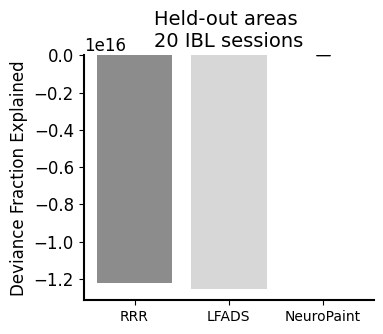

In [20]:
# Prepare data for LFADS and MAE
colors = ['gray', 'lightgray', 'forestgreen']  # Colors for LFADS and MAE
methods = ['RRR', 'LFADS', 'NeuroPaint']  # Only LFADS and MAE

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(dfe_RRR_combine_sessions_remove_inf),
    np.nanmean(dfe_lfads_combine_sessions_remove_inf),
    np.nanmean(dfe_mae_combine_sessions_remove_inf)
]

errors = [
    np.nanstd(dfe_RRR_combine_sessions_remove_inf) / np.sqrt(len(dfe_RRR_combine_sessions_remove_inf)),
    np.nanstd(dfe_lfads_combine_sessions_remove_inf) / np.sqrt(len(dfe_lfads_combine_sessions_remove_inf)),
    np.nanstd(dfe_mae_combine_sessions_remove_inf) / np.sqrt(len(dfe_mae_combine_sessions_remove_inf))
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
ax.set_title('Held-out areas \n20 IBL sessions', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + 'fig3_supp_w_RRR/IBL/IBL_dfe_bar_plot_heldout_ibl_20sessions.pdf', transparent=True)

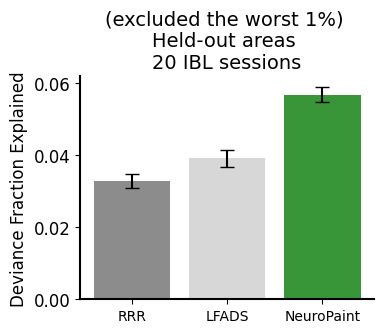

In [ ]:
# Filter data to exclude the worst 1% performers
filter_percent = 1
filtered_RRR = dfe_RRR_combine_sessions_remove_inf[dfe_RRR_combine_sessions_remove_inf > np.quantile(dfe_RRR_combine_sessions_remove_inf, 0.01*filter_percent)]
filtered_lfads = dfe_lfads_combine_sessions_remove_inf[dfe_lfads_combine_sessions_remove_inf > np.quantile(dfe_lfads_combine_sessions_remove_inf, 0.01*filter_percent)]
filtered_mae = dfe_mae_combine_sessions_remove_inf[dfe_mae_combine_sessions_remove_inf > np.quantile(dfe_mae_combine_sessions_remove_inf, 0.01*filter_percent)]

# Prepare data for LFADS and MAE
colors = ['gray', 'lightgray', 'forestgreen']  # Colors for LFADS and MAE
methods = ['RRR', 'LFADS', 'NeuroPaint']  # Only LFADS and MAE

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(filtered_RRR),
    np.nanmean(filtered_lfads),
    np.nanmean(filtered_mae)
]

errors = [
    np.nanstd(filtered_RRR) / np.sqrt(len(filtered_RRR)),
    np.nanstd(filtered_lfads) / np.sqrt(len(filtered_lfads)),
    np.nanstd(filtered_mae) / np.sqrt(len(filtered_mae))
]

# Prepare boxplot data
box_data = [filtered_lfads, filtered_mae]

# Plot bar plot
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
#ax.set_title('LFADS vs MAE \n(Filtered > 5% quantile)', fontsize=14)
ax.set_title(f'(excluded the worst {filter_percent}%) \nHeld-out areas \n20 IBL sessions', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('/work/hdd/bdye/jxia4/results/figures/fig3_supp_w_RRR/IBL/IBL_heldout_region_bar_plot_filtered_w_RRR.pdf', transparent=True)
#plt.show()